1/1 [==============================] - 2s 2s/step


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 126ms/step


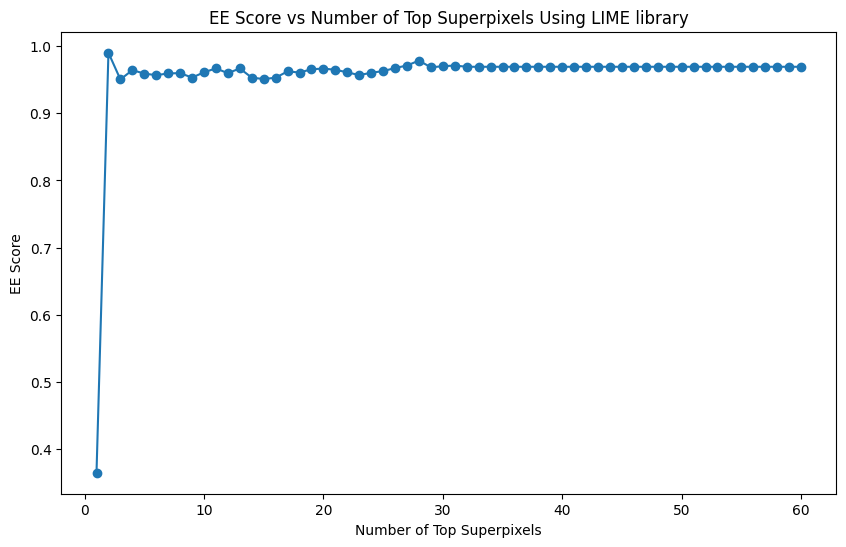

In [18]:
import skimage.io 
import skimage.segmentation
import keras
import numpy as np
from keras.applications.imagenet_utils import decode_predictions
import copy
from tensorflow.keras.applications.inception_v3 import InceptionV3
import lime
from lime import lime_image
import cv2
import matplotlib.pyplot as plt

# Read and preprocess the image
Xi = skimage.io.imread("Image\lion-n02129165\\n02129165_10449.jpg")
Xi = skimage.transform.resize(Xi, (299, 299)) 
Xi = (Xi - 0.5) * 2 

# Load the model
inceptionV3_model = InceptionV3(weights="imagenet")

# Predict the class
preds = inceptionV3_model.predict(Xi[np.newaxis, :, :, :]) 
top_pred_classes = preds[0].argsort()[-5:][::-1]

# Generate superpixels
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4, max_dist=200, ratio=0.2) 
num_superpixels = np.unique(superpixels).shape[0]

# Use LIME to explain the prediction
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(Xi, inceptionV3_model.predict, top_labels=5, hide_color=0, num_samples=500)

# Get the original classification score
R_O = preds[0]

# Function to calculate EE score
def calculate_ee_score(original_scores, perturbed_scores):
    return 1 - np.sum(original_scores * np.abs(original_scores - perturbed_scores))

# Function to calculate EE score for top N superpixels using LIME
def calculate_ee_score_for_top_n(n, explanation, Xi, superpixels, inceptionV3_model, R_O):
    temp, mask = explanation.get_image_and_mask(top_pred_classes[0], positive_only=True, num_features=n, hide_rest=True)
    mask_image = Xi * mask[:, :, np.newaxis]
    preds_masked = inceptionV3_model.predict(mask_image[np.newaxis, :, :, :])
    R_P = preds_masked[0]
    ee_score = calculate_ee_score(R_O, R_P)
    return ee_score

# Calculate EE scores for different numbers of top superpixels
ee_scores = []
num_top_superpixels = []

for n in range(1, num_superpixels + 1):
    ee_score = calculate_ee_score_for_top_n(n, explanation, Xi, superpixels, inceptionV3_model, R_O)
    ee_scores.append(ee_score)
    num_top_superpixels.append(n)



# Plot EE score vs number of top superpixels
plt.figure(figsize=(10, 6))
plt.plot(num_top_superpixels, ee_scores,marker='o')
plt.xlabel('Number of Top Superpixels')
plt.ylabel('EE Score')
plt.title('EE Score vs Number of Top Superpixels Using LIME library')
plt.show()


In [28]:
for i in range(len(ee_scores)):
    if(i==4):
        ee=ee_scores[i]
        
    if ee_scores[i]>=0.9:
        num_of_segment=i
        break

In [29]:
ee

0.9588909931480885

In [21]:

# def perturb_image_with_top_n(n, explanation, Xi, superpixels):
#     _, mask = explanation.get_image_and_mask(top_pred_classes[0],num_features=n)
#     perturbed_image = Xi * mask[:, :, np.newaxis]
#     return perturbed_image,mask

In [30]:

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True)

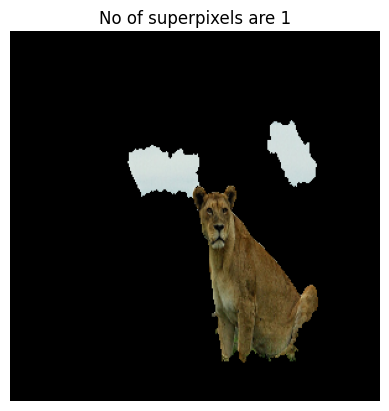

In [31]:
# Mark the boundaries with default behavior (gray)
marked_image = skimage.segmentation.mark_boundaries(temp / 2 + 0.5, mask)

# Iterate over the image and change gray pixels to black
for i in range(marked_image.shape[0]):
    for j in range(marked_image.shape[1]):
        if np.allclose(marked_image[i, j], [0.5, 0.5, 0.5]) or np.allclose(marked_image[i, j], [1, 1, 0]):
            marked_image[i, j] = [0, 0, 0]  # Set gray and yellow pixels to black
plt.imshow(marked_image)
plt.title(f"No of superpixels are {num_of_segment}")
plt.axis('off')
plt.show()

In [32]:
num_pixels_in_segments = np.sum(mask)
print(f'Number of pixels in the top {num_of_segment+1} segments: {num_pixels_in_segments}')
total_num_pixels = Xi.shape[0] * Xi.shape[1]
print(f'Total number of pixels in the entire image: {total_num_pixels}')

print(f"Important segments captures {num_pixels_in_segments*100/total_num_pixels}% area")

Number of pixels in the top 2 segments: 10919
Total number of pixels in the entire image: 89401
Important segments captures 12.213509915996465% area


In [34]:
from skimage import img_as_ubyte
perturbed_image=marked_image
perturbed_image_uint8 = img_as_ubyte(perturbed_image)
skimage.io.imsave('perturbed_image.png', perturbed_image_uint8)

Image to be read
The top 5 classes of predictions are - 
1/1 [==============================] - 0s 120ms/step
[[('n02129165', 'lion', 0.9113959), ('n02125311', 'cougar', 0.062243175), ('n03180011', 'desktop_computer', 0.000541212), ('n02123159', 'tiger_cat', 0.00036304008), ('n07720875', 'bell_pepper', 0.00035313118)]]
[9.19528611e-06 1.30727522e-05 1.44742198e-05 8.76834019e-06
 4.35138827e-05 1.78974460e-05 1.12002663e-05 3.50755363e-05
 8.67221297e-06 1.60683103e-05 7.71443138e-06 1.88907998e-05
 1.46293150e-05 5.41268964e-05 1.93565156e-05 1.71976790e-05
 2.24837786e-05 2.30811056e-05 1.85206154e-05 1.11540157e-05
 1.43159905e-05 5.77500577e-06 3.20443942e-05 4.53107132e-05
 8.89826242e-06 1.00370871e-05 3.37960155e-05 4.08209053e-05
 1.25827028e-05 7.83570067e-06 1.24648313e-05 2.42423248e-05
 1.03634238e-05 3.41719024e-05 1.82642998e-05 6.89996796e-06
 6.83261351e-06 1.20339764e-05 2.53632988e-05 1.99084134e-05
 1.41226592e-05 7.32509761e-06 3.15240104e-05 1.27276971e-05
 1.21869

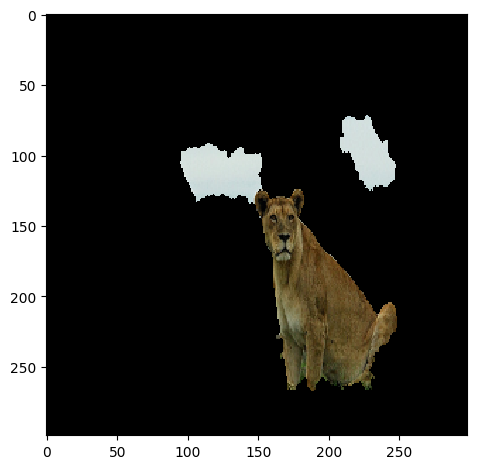

In [35]:
print("Image to be read")
Xi = skimage.io.imread("perturbed_image.png")
Xi = skimage.transform.resize(Xi, (299,299)) 
skimage.io.imshow(Xi)
Xi = (Xi - 0.5)*2 
print("The top 5 classes of predictions are - ")
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:]) 
print(decode_predictions(preds)) #top = 5 default
R_O=preds[0]
print(R_O)